In [2]:
import pandas as pd
import numpy as np
import os
from nice_funcs.indicators import CreateRandomPrtf,EWMA,MACD,RSI,NormalizeWindow
from stable_baselines3 import DDPG ,PPO
from ambiente import TradingEnv


    

def GetIndex(*args):
  indicators = [*args]
  index_init = set(indicators[0].index)
  for ind_ in indicators:
    index_init = index_init & set(ind_.index)
  
  idx_date = min(index_init)
  new_index_indicators = []
  for ind_ in indicators:
    new_index_indicators.append(ind_[idx_date:])
  return new_index_indicators
        


# %%
path_diario = './assets/1d/'
ativos = os.listdir(path_diario)

ativosOHLC = {}
for ativo in ativos:
    ativosOHLC[ativo.replace('.xlsx','')] = \
        pd.read_excel(os.path.join(path_diario,ativo),index_col=0)
    

close_prices = {}
for k in ativosOHLC.keys():
  close_prices[k] = ativosOHLC[k].Close


# %%
df_fechamento = pd.DataFrame(close_prices)
macd = df_fechamento.apply(lambda row: MACD(row)[0]).dropna()
rsi = df_fechamento.apply(lambda row: RSI(row)).dropna()
ewma_diff = df_fechamento.apply(lambda row: EWMA(row,20) - EWMA(row,5)).dropna()
normalized_fech = df_fechamento.apply(lambda row: NormalizeWindow(row)).dropna()

# %%
  

# %%
df_fechamento = pd.DataFrame(close_prices).iloc[-360:]
print(df_fechamento)
macd = df_fechamento.apply(lambda row: MACD(row)[0]).dropna()
rsi = df_fechamento.apply(lambda row: RSI(row)).dropna()
ewma_diff = df_fechamento.apply(lambda row: EWMA(row,20) - EWMA(row,5)).dropna()
normalized_fech = df_fechamento.apply(lambda row: NormalizeWindow(row)).dropna()
df_fechamento,normalized_fech,macd,rsi,ewma_diff =  GetIndex(df_fechamento,normalized_fech, macd, rsi, ewma_diff)


# %%
env = TradingEnv(df_fechamento,[normalized_fech,macd,rsi,ewma_diff])

            ADAUSDT  BNBUSDT   BTCUSDT  ETHUSDT  LTCUSDT  XRPUSDT
Date                                                             
2022-08-10   0.5374    328.8  23954.05  1853.57    61.59   0.3814
2022-08-11   0.5303    323.6  23934.39  1880.19    61.84   0.3802
2022-08-12   0.5402    327.9  24403.68  1958.28    62.88   0.3796
2022-08-13   0.5593    324.3  24441.38  1983.55    63.80   0.3780
2022-08-14   0.5695    317.6  24305.24  1935.31    63.14   0.3757
...             ...      ...       ...      ...      ...      ...
2023-07-31   0.3070    241.0  29232.25  1856.14    92.28   0.6976
2023-08-01   0.3103    247.7  29705.99  1873.47    93.94   0.7069
2023-08-02   0.2993    240.7  29186.01  1839.90    87.54   0.6850
2023-08-03   0.2922    241.1  29193.64  1835.81    82.55   0.6630
2023-08-04   0.2937    241.5  29201.83  1835.98    83.13   0.6662

[360 rows x 6 columns]


In [3]:
model = PPO.load('./Training/Saved Models/trading.zip')

In [4]:
stats = {
  'ganho_total':[],
  'total_turnos':[]}
for _ in range(200):
  obs,_ = env.reset()
  total_ganho = 0
  done = False
  truncated = False
  termination = (done or truncated)
  while not termination:
      action,_ = model.predict(obs)
      obs,reward, done ,truncated,info = env.step(action)
      total_ganho +=reward
      termination = (done or truncated)
  stats['ganho_total'].append(total_ganho)
  stats['total_turnos'].append(env.step_)

**************************************************
Retorno 0.0
[0.19223274 0.07241403 0.19684173 0.07241403 0.19684173 0.19684173
 0.07241403]
[0.20249195 0.07902648 0.2108206  0.07755656 0.2108206  0.0859798
 0.13330406]
[0.07142072 0.07142072 0.19414166 0.08059202 0.19414166 0.19414166
 0.19414166]
[0.09113974 0.09113974 0.09113974 0.09113974 0.20394684 0.24774352
 0.18375069]
[0.20383677 0.07498735 0.20383677 0.16450885 0.07498735 0.20285553
 0.07498735]
[0.12449923 0.12449923 0.12449923 0.15109523 0.22640856 0.12449923
 0.12449923]
[0.09971127 0.14045268 0.18832281 0.2592755  0.09971127 0.11281516
 0.09971127]
[0.113424   0.11718705 0.18825775 0.10184759 0.1965593  0.18087678
 0.10184759]
[0.25269386 0.25269386 0.09296088 0.09296088 0.09296088 0.12276883
 0.09296088]
[0.11168339 0.2164705  0.2164705  0.07963504 0.07963504 0.2164705
 0.07963504]
[0.08470764 0.08555568 0.23025925 0.10549105 0.19387116 0.11684975
 0.18326536]
[0.06575382 0.17609885 0.15914264 0.13322243 0.17873742 0.1

<Axes: ylabel='Frequency'>

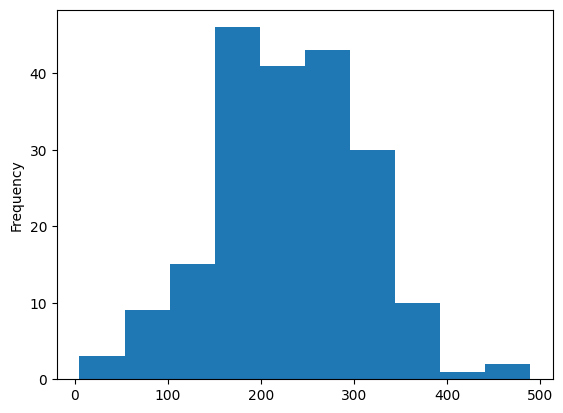

In [5]:
pd.Series(stats['ganho_total']).plot(kind='hist')

In [6]:
pd.Series(stats['ganho_total']).describe()

count    200.000000
mean     230.251905
std       79.915063
min        5.004722
25%      175.399763
50%      227.950040
75%      286.225232
max      489.502989
dtype: float64